**Modelamiento:**

**¿Cómo resolverias este problema?**

1. **Clasificación:** Para esta sección se usará el archivo `data_eda_classification.csv` que contiene datos de tráfico en firewall.

    **Información del dataset**
    - 12 Variables
    - Source Port
    - Destination Port
    - NAT Source Port
    - NAT Destination Port
    - Action
    - Bytes
    - Bytes Sent
    - Bytes Received
    - Packets
    - Elapsed Time (sec)
    - pkts_sent
    - pkts_received

El objetivo de este ejercicio, es explicar como encontraria o crearia una variable útil para la clasificación de los datos en tráficos anómalos o no anómalos. Justifica la elección del o los modelos que usarias para resolver este problema.

# **Solución**

Antes de abordar el problema de clasificación intentemos dar una descripción de cada una de las columnas.
```
12 Variables
Source Port: Número del puerto utilizado por el dispositivo o aplicación que inicializa la comunicación

Destination Port: Puerto al que se dirige el tráfico

NAT Source Port: Puerto de origen NAT (Network Address Translation) es el puerto modificado que se utiliza cuando se realiza traducción de direcciones IP y puertos en un dispositivo NAT, como un firewall o un enrutador. Puede ser relevante para rastrear conexiones de red a través de dispositivos de NAT.

NAT Destination Port:El puerto de destino NAT es el puerto modificado en la dirección de destino cuando se realiza NAT. Ayuda a rastrear las traducciones de puertos y la asignación de puertos para conexiones salientes.

Action: La acción indica lo que ocurrió con el tráfico de red o el paquete de datos

Bytes: Es la suma de Bytes enviados mas recibidos

Bytes Sent:La cantidad de bytes enviados desde la fuente

Bytes Received:cantidad de bytes recibidos en el destino

Packets:  El número total de paquetes transmitidos en la comunicación

Elapsed Time (sec): El tiempo transcurrido en segundos durante la comunicación o el evento

pkts_sent:El número de paquetes enviados desde la fuente

pkts_received: El número de paquetes recibidos en el destino

Veamos el contenido del archivo `data_eda_classification`

```

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data_eda_classification.csv')

In [3]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


Los valores atípicos en un conjunto de datos tienen diferentes maneras de agruparse de acuerdo al contexto. A continuación mencionaremos algunas maneras en las que podemos obtener estos.

Una primera aproximación a estos datos atípicos para estableces conexiones anómalas puede ser utilizando la variable estadística `Bytes` si la cantidad de Bytes intercambiados en una conexión es excesivamente alta podemos sospechar de este dato. Esto lo podemos visualizar a través de diagramas de caja o `Boxplot`

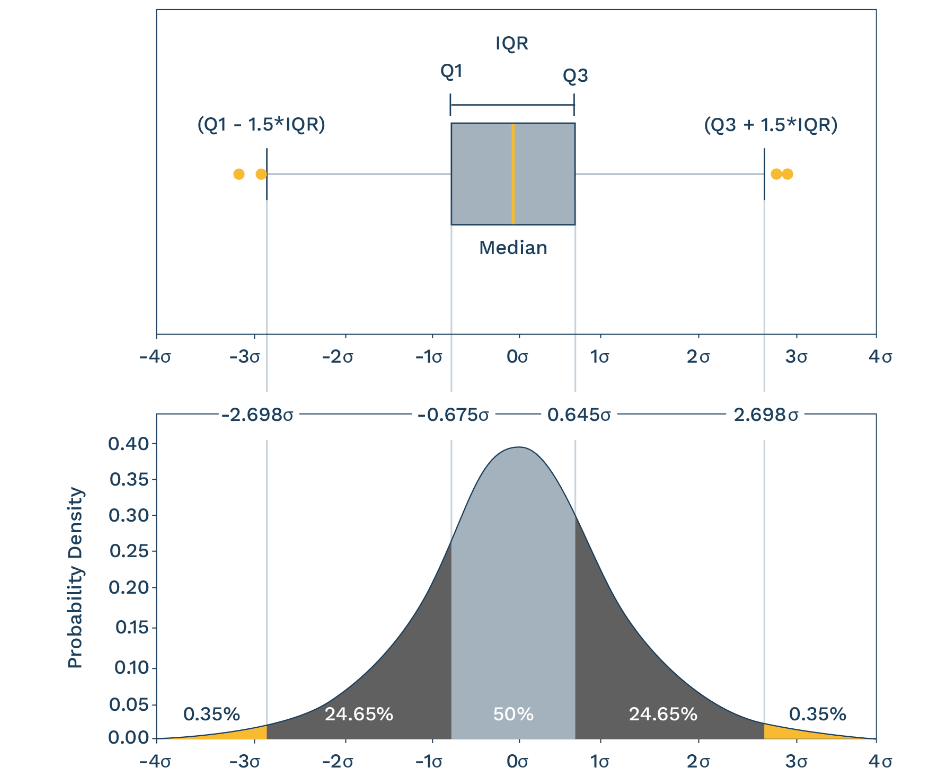

Con estos diagramas podemos visualizar que la mayor parte de los datos está concentrada en la región entre los extremos de los bigotes del diagrama de caja. Fuera de estos extremos se encuentran los datoa que se reportarían como atípicos. sin embargo, este tipo de conexiones y transferencia de grandes cantidades de bytes puede no siempre corresponder a una anomalía por lo que se pueden construir muchas otras medidas. a continuación mencionaré algunas

**Analizando la columna Bytes**

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

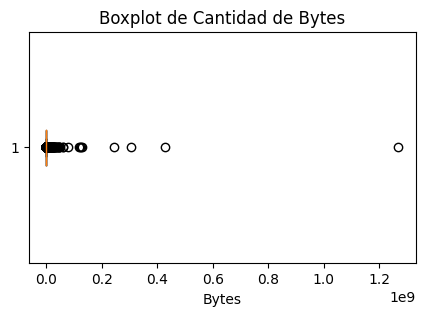

In [6]:
plt.figure(figsize=(5, 3))
plt.boxplot(df['Bytes'], vert=False)
plt.title('Boxplot de Cantidad de Bytes')
plt.xlabel('Bytes')
plt.show()

In [7]:
#import pandas as pd

# Supongamos que tienes un DataFrame llamado "data" y la columna se llama "bytes".
# Puedes acceder a la columna de bytes de esta manera: data['bytes']

# Calcular el rango intercuartil (IQR)
Q1 = df['Bytes'].quantile(0.25)
Q3 = df['Bytes'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para valores atípicos
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Contar valores atípicos
valores_atipicos = df[(df['Bytes'] < limite_inferior) | (df['Bytes'] > limite_superior)]
cantidad_valores_atipicos = len(valores_atipicos)

print(f"Cantidad de valores atípicos: {cantidad_valores_atipicos}")


Cantidad de valores atípicos: 12979


Hay tantos datos atípicos tan grandes fuera de la caja que no se alcanzan a vizualizar los extremos de los bigotes, tenemos en total  12979, que corresponden al $\frac{12979}{65532} =0,1981 $, es decir el $19,81$ % de los datos

**Construyendo una mejor métrica**

In [8]:
df2 = pd.DataFrame(data = df['Packets']/df['Bytes'],columns=['Packets-Bytes'])

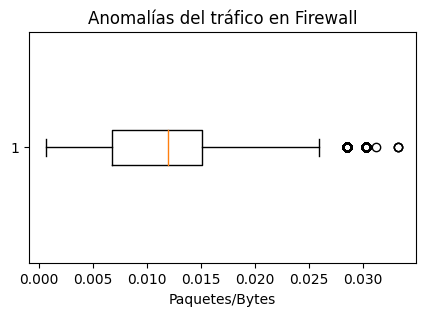

In [9]:
plt.figure(figsize=(5, 3))
plt.boxplot(df2['Packets-Bytes'], vert=False)  # vert=False para que los boxes estén en horizontal
plt.title('Anomalías del tráfico en Firewall')
plt.xlabel('Paquetes/Bytes')
plt.show()

In [10]:
# Calcular el rango intercuartil (IQR)
Q1 = df2['Packets-Bytes'].quantile(0.25)
Q3 = df2['Packets-Bytes'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para valores atípicos
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Contar valores atípicos
valores_atipicos = df2[(df2['Packets-Bytes'] < limite_inferior) | (df2['Packets-Bytes'] > limite_superior)]
cantidad_valores_atipicos = len(valores_atipicos)

print(f"Cantidad de valores atípicos: {cantidad_valores_atipicos}")

Cantidad de valores atípicos: 1098


Ahora la cantidad de datos atípicos está mucho más acotada y la métrica tiene mucha más precisión, pues en lugar de analizar solo una columna está analizando 2 y creando una relación entre estas

Podemos análogamente seguir involucrando más medidas, por ejemplo que la proporción anterior sea grande y que el tiempo de comunicación `Elapsed Time (sec)` sea muy corto o muy grande, es decir, esté fuera de un rango de valores determinado. O quizá en general la transferencia de paquetes grandes se realice por uno o algunos puertos específicos, aquí también estaríamos involucrando el puerto. en resumen nos daríamos cuenta que entre más variables pongamos, estamos imponiendo más condiciones al registro para determinar la categoría `Anómalo` o `No-Anómalo`

#### **Ayudas Computacionales para la detección de Outliers**

Existen herramientas computacionales que nos pueden ayudar en la detección de anomalías, un ejemplo de esto es la librería de `sklearn` con la clase `IsolationForest`. Este método está basado en árboles de decisión, la idea consiste en que las anomalías necesitan menos ramas para ser aisladas que los datos normales. Debemos además pasarle un parámetro de contaminación así que debemos conocer a priori qué qué porcentaje de nuestro dataset puede contener anomalías. Usemos el porcentaje encontrado anteriormente como contaminación, es decir, $\frac{1098}{65532}=0,0168$

Nota: -1 representa anomalía y 1 representa no anomalía

In [11]:
from sklearn.ensemble import IsolationForest
X = df[['Bytes','Packets']]

# Aplicar el modelo Isolation Forest
iso_forest = IsolationForest(contamination=0.0168)
iso_forest.fit(X)
df['Isolation Forest Anomaly'] = iso_forest.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [12]:
df.tail()


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Isolation Forest Anomaly
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2,1
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690,-1
65529,54871,445,0,0,drop,70,70,0,1,0,1,0,1
65530,54870,445,0,0,drop,70,70,0,1,0,1,0,1
65531,54867,445,0,0,drop,70,70,0,1,0,1,0,1


In [13]:
df['Isolation Forest Anomaly'].value_counts()

 1    64431
-1     1101
Name: Isolation Forest Anomaly, dtype: int64

El modelo `Isolation Forest Anomaly` encontro 1115 anomalías. Podria ser interesante comparar los Outliers generados por el diagrama de caja con las anomalías que genera el modelo `Isolation Forest Anomaly` y ver si hay algún tipo de correspondencia o cuál de los dos se ajusta mejor a las necesidades de la compañía